# Makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
vocab_size = len(stoi)
vocab_size

27

In [56]:
block_size = 3 # Context length

# Build the dataset
def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("[",''.join(itos[i] for i in context),']', '--->', itos[ix])
            # print(','.join(str(i) for i in context))
            context = context[1:] + [ix] # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [91]:
# Dimensionality of the character embedding vectors
n_embd = 10 
# Number of neurons in the hidden layer of the MLP
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),                       generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),           generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                                  generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),                    generator=g) * 0.01
b2 = torch.randn(vocab_size,                                generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True


In [81]:
# Set the s.d of our weights
(5/3) / (30**0.5)

0.3042903097250923

In [92]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # Embed the chars into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + # b1 Hidden layer pre-activation...#

    # WITH BATCHNORM YOU DON'T NEED A BIAS!!!


    # BatchNorm layer!
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnmean_running + 0.001 * bnstdi

    # Non-linearity
        # Update mean & std
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Output layer
    loss = F.cross_entropy(logits, Yb) # Loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01 if i < 100000 / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    
    


      0/ 200000: 3.3181
   1000/ 200000: 2.8309
   2000/ 200000: 2.6993
   3000/ 200000: 2.6744
   4000/ 200000: 2.4851
   5000/ 200000: 2.1728
   6000/ 200000: 2.3241
   7000/ 200000: 2.3148
   8000/ 200000: 2.5147
   9000/ 200000: 2.7301
  10000/ 200000: 2.6731
  11000/ 200000: 2.4192
  12000/ 200000: 2.3106
  13000/ 200000: 2.2203
  14000/ 200000: 2.4355
  15000/ 200000: 2.3538
  16000/ 200000: 2.1083
  17000/ 200000: 1.9603
  18000/ 200000: 2.2371
  19000/ 200000: 2.0241
  20000/ 200000: 2.8238
  21000/ 200000: 2.8684
  22000/ 200000: 2.5229
  23000/ 200000: 2.4656
  24000/ 200000: 2.1004
  25000/ 200000: 2.6186
  26000/ 200000: 2.0392
  27000/ 200000: 2.0773
  28000/ 200000: 2.2658
  29000/ 200000: 2.4588
  30000/ 200000: 2.2332
  31000/ 200000: 2.1156
  32000/ 200000: 2.4917
  33000/ 200000: 2.5900
  34000/ 200000: 2.2887
  35000/ 200000: 2.1232
  36000/ 200000: 2.5812
  37000/ 200000: 2.2342
  38000/ 200000: 1.9888
  39000/ 200000: 2.0654
  40000/ 200000: 2.1538
  41000/ 200000:

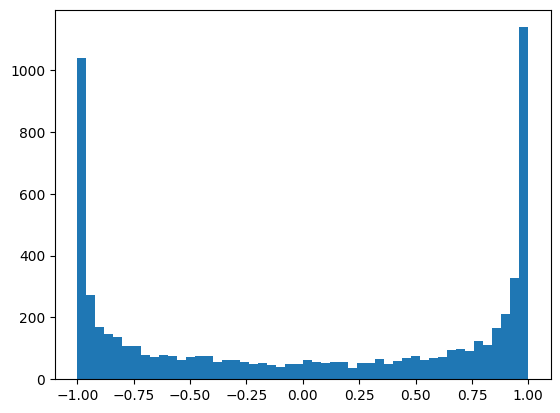

In [84]:
# Let's look closer at h... what happens after tanh?
# print(h.shape)
# print(h.view(-1).shape)
plt.hist(h.view(-1).tolist(), 50);

# Very active function...

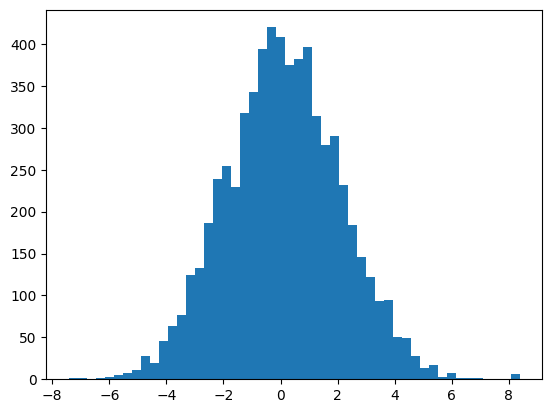

In [85]:
# Let's look closer at the pre-activations into the tanh

plt.hist(hpreact.view(-1).tolist(), 50);

# Very broad... Normal dist.

### Important: when tanh is 1 or -1, we are effectively KILLING the gradient: bad.

We are in the tail of the tanh. Changing the input won't change the output of the tanh too much, and there is not much impact on the loss......
The W and b don't really impact this unit.

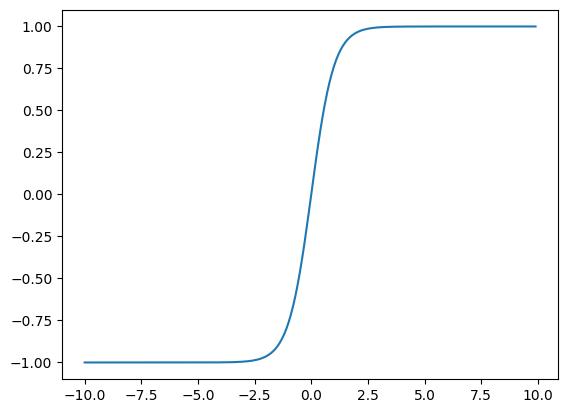

In [90]:
x = torch.arange(-10, 10, 0.1)
y = torch.tanh(x)

plt.plot(x, y)
plt.show()

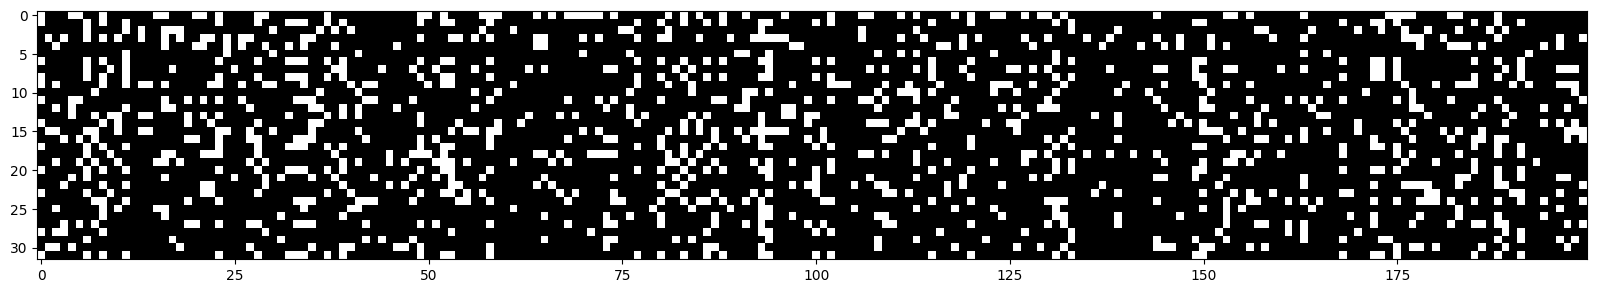

In [86]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')

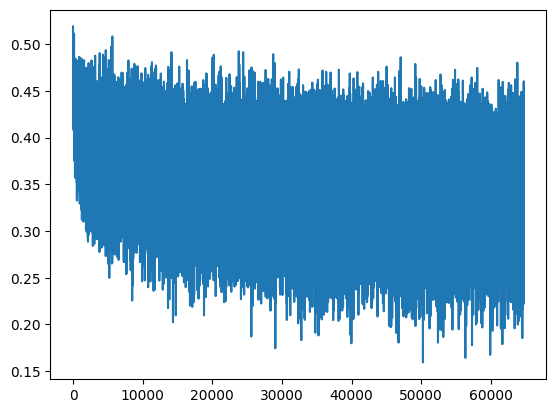

In [87]:
plt.plot(lossi)

In [ ]:
#  Calibrate the batch norm at the end of training

# DONE VIA RUNNING MEAN AND 

# with torch.no_grad():
#     # Pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     #  Measure the mean / std over the entire training set
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [93]:
@torch.no_grad() # This decorator disables gradient tracking, because we aren't going to do a backward pass
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

    hpreact = embcat @ W1 + b1
    # Batch normalisation!
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) # Loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.128758668899536
val 2.1530630588531494


In [18]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):

    out = []
    context = [0] * block_size
    while True:
        # Forward pass the neural net
        emb = C[torch.tensor([context])] #(1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


sai.
kiame.
kyara.
pasdahaira.
kaylen.
khen.
bry.
abruan.
anqkee.
katlon.
zivie.
dymorio.
nliny.
davir.
.
madyr.
raz.
aeri.
semoryan.
koisa.
kanteleer.
eirlie.
sresttfartanannyy.
sori.
mon.
calyi.
koinor.
thyannah.
raijayella.
eashynh.


In [19]:
# So far, so good, only that at initialisation, we record a SUPER high loss, one that is abnormally high.
# Given only 27 chars, we'd expect a uniformly random distribution to get a loss of:
- torch.tensor(1/27.0).log()

tensor(3.2958)

In [28]:
# logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
logits = torch.zeros(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))